In [2]:
# import importlib
from MDSimulation import MDSimulation

In [3]:
%%bash
cd initial_trial

for i in {2..4}
do 
    cp -r initial_trial_1 initial_trial_$i
done

Process is interrupted.


In [8]:
# SIMULATION PARAMETERS + FILES
simutlation_steps = 500000 # 500000*0.002 ps >> 1000ps = 1ns
plumed_file_name = 'plumed_initial.dat' 
threshold_val = 2.5 # Dissociation distance [nm]: Cut-off distance for simulation to stop when threshold value reached

In [9]:
#
for i in range(1,5):
    print('***** Currently Running %i round of simulation******'%i)
    sim_directory = 'initial_trial_%i'%i
    md_sim = MDSimulation(work_dir='/initial_trial/'+ sim_directory)
    
    with md_sim.working_directory():
    
        md_sim.remove_previous_old_files()
    
        #simulation Set-Up
        simulation = md_sim.simulation_preperation(equilibration=False)
        positions = simulation.context.getState(getPositions=True).getPositions()
        #Run Simulation Here >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
        md_sim.run_MD(simulation, positions, nsteps=simutlation_steps, report_steps=False, committor=True, 
                      use_plumed=True, plumed_file=plumed_file_name, stride=500, threshold=threshold_val)
        
        md_sim.remove_last_line()
        # md_sim.combine_xtc_files()
       


*****Currently Running 1 round of ******
===== Load pre-Equilibrated system Checkpoint file =====
PLUMED:                                               Cycles        Total      Average      Minimum      Maximum
PLUMED:                                                    1     0.612598     0.612598     0.612598     0.612598
PLUMED: 1 Prepare dependencies                          3001     0.004848     0.000002     0.000001     0.000021
PLUMED: 2 Sharing data                                  3001     0.276658     0.000092     0.000086     0.003224
PLUMED: 3 Waiting for data                              3001     0.000800     0.000000     0.000000     0.000001
PLUMED: 4 Calculating (forward loop)                    3001     0.053529     0.000018     0.000006     0.000193
PLUMED: 5 Applying (backward loop)                      3001     0.233024     0.000078     0.000068     0.000179
PLUMED: 6 Update                                        3000     0.014482     0.000005     0.000001     0.00108

In [52]:
    def remove_last_line(file_path='COLVAR'):
        with open(file_path, 'r') as file:
            lines = file.readlines()
        with open(file_path, 'w') as file:
            file.writelines(lines[:-50])

In [13]:
!pwd

/ocean/projects/che180027p/slee1/FKBP_openmm/FKBP/SPIB_kinetics/initial_trial/initial_trial_4


In [14]:
# %cd ../initial_trial/initial_trial_4
remove_last_line()

TypeError: remove_last_line() missing 1 required positional argument: 'self'

In [18]:
!pwd
%cd ../

/ocean/projects/che180027p/slee1/FKBP_openmm/FKBP/SPIB_kinetics/initial_trial
/ocean/projects/che180027p/slee1/FKBP_openmm/FKBP/SPIB_kinetics


In [10]:
!pwd
%ls

/ocean/projects/che180027p/slee1/FKBP_openmm/FKBP/SPIB_kinetics
01_metaD/              MDSimulation.py      SPIB02/             main.ipynb
02_inMetaD/            MDSimulation_old.py  __pycache__/        run_Md.ipynb
FKBP_openmm/           README.md            google_colab.ipynb
FKBP_openmm_original/  SPIB01/              initial_trial/


## Select appropriate OPs for SPIB tranining 

In [19]:
%cd SPIB01

/ocean/projects/che180027p/slee1/FKBP_openmm/FKBP/SPIB_kinetics/SPIB01


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
from torch import nn
import importlib.util
from sklearn.cluster import KMeans
from itertools import groupby
import sys
import os
if not os.path.exists('data/'):
    os.mkdir('data')

In [22]:
data_list=[]
data_list_str=[]

for i in range(1,5):
    print(i)
    locals()['metaD{0}'.format(i)] = np.loadtxt('../initial_trial/initial_trial_%i/COLVAR'%(i))
    data_list.append(locals()['metaD{0}'.format(i)])
    data_list_str.append('metaD{0}'.format(i))



(28250, 32)
(28300, 32)
(25250, 32)
(40647, 32)


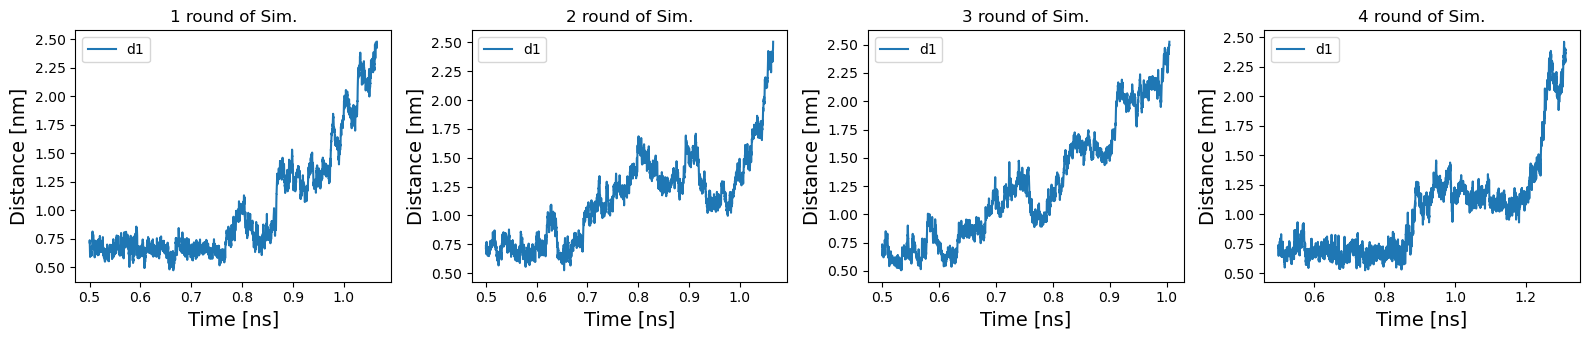

In [35]:
# visualize the data and also initiate K-mean Clustering +Labeling

plt.figure(figsize=(16,3.5))

for i, simulation_data in enumerate(data_list): 

    print(simulation_data.shape)

    distance = simulation_data[:,[0,-3]] # take time and the 426th colums of data that correspond to the distance
    bias = simulation_data[:,[-2,-1]] 
    bias_distance = simulation_data[:,[0,-4]] 
    traj_raw = simulation_data[:,[-3,-4]]

    time = bias_distance[:,0]/1000
    
    plt.subplot(1,4,i+1)
    # plot distance between the COM on ligand and COM on protein to observe the dissociation
    plt.plot(time,distance[:,1],label='d1')
    plt.xlabel('Time [ns]',fontsize=14)
    plt.ylabel('Distance [nm]',fontsize=14)
    plt.legend()
    plt.title('%i round of Sim.'%(i+1))

    ######
    # One-hot encoded initial state assignment: Using K-mean clustering
    ######
    num_labels = 20
    data = list(zip(traj_raw[:,0],traj_raw[:,1]))
    kmeans = KMeans(n_clusters= num_labels , random_state=0).fit(data)

    one_hot_labels = np.zeros((traj_raw.shape[0], num_labels))
    one_hot_labels[np.arange(traj_raw.shape[0]),kmeans.labels_] = 1
    file_name = data_list_str[i]

    # Save one-hot encoded initial states
    np.save('data/labels_'+str(file_name)+'.npy', one_hot_labels)

    # Create and save all 425 different OP as an SPIB input with normalization
    FKBP_distance_mean = np.mean(simulation_data[:,1:29], axis=0)
    FKBP_distance_std = np.std(simulation_data[:,1:29], axis=0)

    np.save('data/FKBP_distance_data_mean.npy', FKBP_distance_mean)    
    np.save('data/FKBP_distance_data_std.npy', FKBP_distance_std)  

    distance_simulation_data = simulation_data[:,1:29] 
    
    traj_path_SPIB_OP = (distance_simulation_data-FKBP_distance_mean)/FKBP_distance_std #normalized trajectory data
    np.save('data/normalized_traj_path_'+str(file_name)+'.npy', traj_path_SPIB_OP)

plt.tight_layout()
# Combine all SPIB output data files for all 4 trajectories
concatenate_data = np.concatenate(data_list, axis=0)[:,1:29]

concatenate_data_mean = np.mean(concatenate_data, axis=0)
concatenate_data_std = np.std(concatenate_data, axis=0)

np.save('data/FKBP_distance_data_mean.npy', concatenate_data_mean)    
np.save('data/FKBP_distance_data_std.npy', concatenate_data_std)  
    

## RUN SPIB stage 1

In [36]:
# # run SPIB with the selected hyperparameters in the sample_config.ini files on here 6 trajectories 
!python SPIB_scripts/test_model_advanced.py -config data/sample_config.ini


Iteration 500:	Time 2.678092 s
Loss (train) 2.990245	KL loss (train): 4.292532
Reconstruction loss (train) 2.989815
Loss (test) 2.992605	KL loss (test): 3.489473
Reconstruction loss (test) 2.992256
tensor([0.0000, 0.0000, 0.0424, 0.6893, 0.0000, 0.0000, 0.0440, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.1932, 0.0000, 0.0312, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000], device='cuda:0')
State population change=0.659835
Update lr to 0.000010
Epoch: 1

Iteration 1000:	Time 4.290603 s
Loss (train) 2.975125	KL loss (train): 3.511506
Reconstruction loss (train) 2.974774
Loss (test) 2.979115	KL loss (test): 4.107876
Reconstruction loss (test) 2.978704
Iteration 1500:	Time 5.687898 s
Loss (train) 2.941976	KL loss (train): 5.065943
Reconstruction loss (train) 2.941469
Loss (test) 2.939971	KL loss (test): 5.255935
Reconstruction loss (test) 2.939445
tensor([0.0000, 0.0000, 0.2079, 0.6915, 0.0000, 0.0000, 0.0744, 0.0000, 0.0000,
        0.0000, 0.0262, 0.0000, 0.0000, 0.0000, 0.0000, 0

Iteration 23500:	Time 51.245974 s
Loss (train) 0.311054	KL loss (train): 20.256016
Reconstruction loss (train) 0.309029
Loss (test) 0.283985	KL loss (test): 20.419439
Reconstruction loss (test) 0.281943
tensor([0.0000, 0.0000, 0.0000, 0.1890, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6152, 0.0000,
        0.0000, 0.1958])
State population change=0.000986
Update lr to 0.000010
Epoch: 2

Iteration 24000:	Time 52.369186 s
Loss (train) 0.317012	KL loss (train): 19.718403
Reconstruction loss (train) 0.315040
Loss (test) 0.364963	KL loss (test): 21.397459
Reconstruction loss (test) 0.362823
Iteration 24500:	Time 53.300247 s
Loss (train) 0.356641	KL loss (train): 22.042898
Reconstruction loss (train) 0.354436
Loss (test) 0.325609	KL loss (test): 21.466768
Reconstruction loss (test) 0.323462
tensor([0.0000, 0.0000, 0.0000, 0.1896, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.000

## Generate Plume file from learn RC for MetaD

In [23]:
!pwd

/ocean/projects/che180027p/slee1/FKBP_openmm/FKBP/SPIB_kinetics/SPIB01


In [38]:
!python plumed_generator.py

===== First updated sigma for RC 1 and RC2 ======
[sigma_1,sigma_2] =  [0.2956803 0.3344098]


In [39]:
!mv data/plumed_metaD_ANN.dat ../01_metaD/01_metaD1

In [43]:
!pwd

/ocean/projects/che180027p/slee1/FKBP_openmm/FKBP/SPIB_kinetics/SPIB01


## Prepare for first SPIB stage of metadynmaics 

In [44]:
%%bash
cd ../01_metaD

for i in {2..4}
do 
    cp -r 01_metaD1 01_metaD$i
done


In [41]:
## SIMULATION PARAMETERS + FILES
simutlation_steps = 500000 # 500000*0.002 ps >> 1000ps = 1ns
plumed_file_name = 'plumed_metaD_ANN.dat' 
threshold_val = 2.5 # Dissociation distance [nm]: Cut-off distance for simulation to stop when threshold value reached

In [47]:
!pwd
%cd ../

/ocean/projects/che180027p/slee1/FKBP_openmm/FKBP/SPIB_kinetics/SPIB01
/ocean/projects/che180027p/slee1/FKBP_openmm/FKBP/SPIB_kinetics


In [48]:
for i in range(1,5):
    print('***** Currently Running %i round of simulation******'%i)
    sim_directory = '/01_metaD%i'%i
    md_sim = MDSimulation(work_dir='/01_metaD'+ sim_directory)
    
    with md_sim.working_directory():
    
        md_sim.remove_previous_old_files()
    
        #simulation Set-Up
        simulation = md_sim.simulation_preperation(equilibration=False)
        positions = simulation.context.getState(getPositions=True).getPositions()
        #Run Simulation Here >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
        md_sim.run_MD(simulation, positions, nsteps=simutlation_steps, report_steps=False, committor=True, 
                      use_plumed=True, plumed_file=plumed_file_name, stride=500, threshold=threshold_val)
        
        md_sim.remove_last_line()
        # md_sim.combine_xtc_files()

***** Currently Running 1 round of simulation******
===== Load pre-Equilibrated system Checkpoint file =====
PLUMED:                                               Cycles        Total      Average      Minimum      Maximum
PLUMED:                                                    1   175.238983   175.238983   175.238983   175.238983
PLUMED: 1 Prepare dependencies                        407001     0.675526     0.000002     0.000001     0.000034
PLUMED: 2 Sharing data                                407001    37.685739     0.000093     0.000086     0.003227
PLUMED: 3 Waiting for data                            407001     0.115377     0.000000     0.000000     0.000020
PLUMED: 4 Calculating (forward loop)                  407001     7.670619     0.000019     0.000006     0.001396
PLUMED: 5 Applying (backward loop)                    407001    31.885326     0.000078     0.000070     0.001860
PLUMED: 6 Update                                      407000    94.662121     0.000233     0.000001 

In [25]:
%cd SPIB02

/ocean/projects/che180027p/slee1/FKBP_openmm/FKBP/SPIB_kinetics/SPIB02


In [26]:
!pwd

/ocean/projects/che180027p/slee1/FKBP_openmm/FKBP/SPIB_kinetics/SPIB02


In [27]:
data_list=[]
data_list_str=[]

for i in range(1,5):
    locals()['metaD{0}'.format(i)] = np.loadtxt('../01_metaD/01_metaD%i/COLVAR'%(i))
    data_list.append(locals()['metaD{0}'.format(i)])
    data_list_str.append('metaD{0}'.format(i))



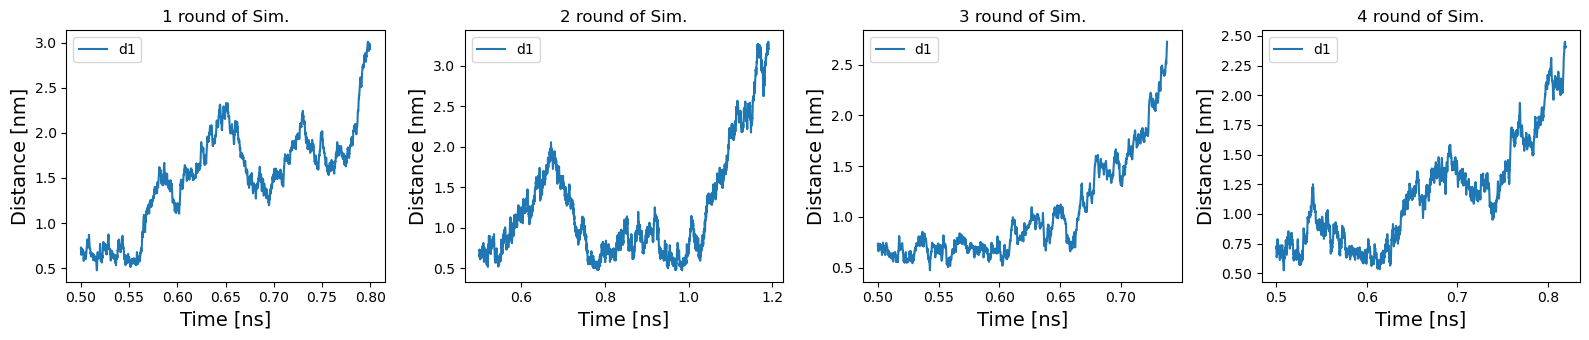

In [76]:

# visualize the data 
plt.figure(figsize=(16,3.5))
for i, simulation_data in enumerate(data_list): 
    # print(simulation_data.shape)

    distance = simulation_data[:,[0,-5]] # take time and the 426th columns of data that correspond to the distance
    bias = simulation_data[:,[-2,-1]] 
    bias_distance = simulation_data[:,[0,-5]] 
    traj_raw = simulation_data[:,[-4,-3]]
    
    time = bias_distance[:,0]/1000
    
    plt.subplot(1,4,i+1)
    # plot distance between the COM on ligand and COM on protein to observe the dissociation
    plt.plot(time,distance[:,1],label='d1')
    plt.xlabel('Time [ns]',fontsize=14)
    plt.ylabel('Distance [nm]',fontsize=14)
    plt.legend()
    plt.title('%i round of Sim.'%(i+1))

#     #####
#     One-hot encoded initial state assignment: Using K-mean clustering
#     #####
    num_labels = 20
    data = list(zip(traj_raw[:,0],traj_raw[:,1]))
    kmeans = KMeans(n_clusters= num_labels , random_state=0).fit(data)

    one_hot_labels = np.zeros((traj_raw.shape[0], num_labels))
    one_hot_labels[np.arange(traj_raw.shape[0]),kmeans.labels_] = 1
    file_name = data_list_str[i]

    # Save one-hot encoded initial states
    np.save('data/labels_'+str(file_name)+'.npy', one_hot_labels)

    # Create and save all 425 different OP as an SPIB input with normalization
    FKBP_distance_mean = np.mean(simulation_data[:,1:29], axis=0)
    FKBP_distance_std = np.std(simulation_data[:,1:29], axis=0)

    np.save('data/FKBP_distance_data_mean.npy', FKBP_distance_mean)    
    np.save('data/FKBP_distance_data_std.npy', FKBP_distance_std)  

    distance_simulation_data = simulation_data[:,1:29] 
    
    traj_path_SPIB_OP = (distance_simulation_data-FKBP_distance_mean)/FKBP_distance_std #normalized trajectory data
    np.save('data/normalized_traj_path_'+str(file_name)+'.npy', traj_path_SPIB_OP)

plt.tight_layout()

## RUN SPIB stage 2

In [ ]:
# run SPIB with the selected hyperparameters in the sample_config.ini files on here 6 trajectories 
!python SPIB_scripts/test_model_advanced.py -config data/sample_config.ini


Iteration 500:	Time 2.721786 s
Loss (train) 2.982186	KL loss (train): 3.278951
Reconstruction loss (train) 2.981858
Loss (test) 2.984114	KL loss (test): 4.012295
Reconstruction loss (test) 2.983713
tensor([0.0000, 0.0000, 0.0000, 0.5717, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0696, 0.3588, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000], device='cuda:0')
State population change=0.635578
Update lr to 0.000010
Epoch: 1

Iteration 1000:	Time 4.545846 s
Loss (train) 2.973529	KL loss (train): 3.588263
Reconstruction loss (train) 2.973170
Loss (test) 2.956061	KL loss (test): 3.938098
Reconstruction loss (test) 2.955667
tensor([0.0000, 0.0000, 0.0000, 0.3200, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.2345, 0.0000, 0.0247, 0.4074, 0.0000, 0.0000, 0.0135, 0.0000, 0.0000,
        0.0000, 0.0000], device='cuda:0')
State population change=0.350524
Update lr to 0.000010
Epoch: 2

Iteration 1500:	Time 6.424841 s
Loss (train) 2.934768	KL loss (train)

Iteration 20000:	Time 44.857050 s
Loss (train) 0.313263	KL loss (train): 19.030046
Reconstruction loss (train) 0.311360
Loss (test) 0.258217	KL loss (test): 18.504194
Reconstruction loss (test) 0.256367
tensor([0.0000, 0.4084, 0.0000, 0.0000, 0.5916, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000])
State population change=0.006123
Update lr to 0.000010
Epoch: 2

Iteration 20500:	Time 45.947243 s
Loss (train) 0.283704	KL loss (train): 19.720860
Reconstruction loss (train) 0.281731
Loss (test) 0.301793	KL loss (test): 20.743874
Reconstruction loss (test) 0.299719
tensor([0.0000, 0.4107, 0.0000, 0.0000, 0.5893, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000])
State population change=0.003188
Update lr to 0.000010
Epoch: 3

Iteration 21000:	Time 47.035142 s
Loss (train) 0.318800	KL loss (train): 19.571968
Reconstruct

## Generate Plume file from learn RC for MetaD


In [29]:
!python plumed_generator_v2.py

===== First updated sigma for RC 1 and RC2 ======
[sigma_1,sigma_2] =  [0.2839388  0.27639738]


In [30]:
!mv data/plumed_metaD_ANN.dat ../02_inMetaD/02_inMetaD1

In [31]:
!pwd

/ocean/projects/che180027p/slee1/FKBP_openmm/FKBP/SPIB_kinetics/SPIB02


## Prepare for Second SPIB stage/ Final infrequent metadynamics 

In [32]:
%%bash
cd ../02_inMetaD

for i in {2..4}
do 
    cp -r 02_inMetaD1 02_inMetaD$i
done

In [33]:
## SIMULATION PARAMETERS + FILES
simutlation_steps = 2000000 # 500000*0.002 ps >> 1000ps = 1ns
plumed_file_name = 'plumed_metaD_ANN.dat' 
threshold_val = 2.5 # Dissociation distance [nm]: Cut-off distance for simulation to stop when threshold value reached


In [36]:
%cd ../

/ocean/projects/che180027p/slee1/FKBP_openmm/FKBP/SPIB_kinetics


In [37]:

for i in range(1,5):
    print('***** Currently Running %i round of simulation******'%i)
    sim_directory = '02_inMetaD%i'%i
    md_sim = MDSimulation(work_dir='/02_inMetaD/'+ sim_directory)
    
    with md_sim.working_directory():
    
        md_sim.remove_previous_old_files()
    
        #simulation Set-Up
        simulation = md_sim.simulation_preperation(equilibration=False)
        positions = simulation.context.getState(getPositions=True).getPositions()
        #Run Simulation Here >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
        md_sim.run_MD(simulation, positions, nsteps=simutlation_steps, report_steps=False, committor=True, 
                      use_plumed=True, plumed_file=plumed_file_name, stride=500, threshold=threshold_val)
        
        md_sim.remove_last_line()
        # md_sim.combine_xtc_files()

***** Currently Running 1 round of simulation******
===== Load pre-Equilibrated system Checkpoint file =====
PLUMED: PLUMED is starting
PLUMED: Version: 2.7.3 (git: Unknown) compiled on Dec  1 2021 at 12:51:58
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /jet/home/slee1/micromamba/envs/thermomaps/lib/plumed
PLUMED: For installed feature, see /jet/home/slee1/micromamba/envs/thermomaps/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: OpenMM
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 28368
PLUMED: File suffix: 
PLUMED: Timestep: 0.002000
PLUMED: KbT has not been set by the MD engine
PLUMED: It should be set by hand where needed
PLUMED: Relevant bibliography:
PLUMED:   [1] The PLUMED consortium, Nat. Methods 16, 670 (2019)
PLUMED:   [2] Tribello, Bonomi, Branduardi, Ca

In [58]:
!pwd

/ocean/projects/che180027p/slee1/FKBP_openmm/FKBP/SPIB_kinetics/02_inMetaD/02_inMetaD4


In [59]:
%cd ../../
!ls

/ocean/projects/che180027p/slee1/FKBP_openmm/FKBP/SPIB_kinetics
01_metaD     FKBP_openmm_original  README.md  __pycache__	  initial_trial
02_inMetaD   MDSimulation.py	   SPIB01     data		  main.ipynb
FKBP_openmm  MDSimulation_old.py   SPIB02     google_colab.ipynb  run_Md.ipynb


In [56]:
%cd ../02_inMetaD4
remove_last_line()

/ocean/projects/che180027p/slee1/FKBP_openmm/FKBP/SPIB_kinetics/02_inMetaD/02_inMetaD4


In [60]:
data_list_2=[]
data_list_str_2=[]

for i in range(1,4):
    locals()['inMetaD{0}'.format(i)] = np.loadtxt('02_inMetaD/02_inMetaD%i/COLVAR'%(i))
    data_list_2.append(locals()['inMetaD{0}'.format(i)])
    data_list_str_2.append('inMetaD{0}'.format(i))



## Calculate residence time and curve fit

In [61]:
residence_t_data = []


# def residence_t():

# Loop over the data points in 'data_list'
for i in range(len(data_list)):
    simulation_data = data_list[i]
    # Extract the time and bias columns from the simulation data
    time = simulation_data[:,0]
    bias = simulation_data[:,-2]
    # Calculate the time step (dt)
    dt = (time[-1]-time[-2])*1e-12
    k_B = 8.314462 
    T = 300 
    kbT = k_B*T/1000 
    
    # Calculate the acceleration factor
    acceleration = np.exp(bias/kbT)
    residence_t = acceleration*dt
    residence_t = np.sum(residence_t)
    print(residence_t)
    # Add the calculated residence time to the list of residence time data
    residence_t_data.append(residence_t)


4.336688503158523e-09
6.189812612314904e-07
4.624647563931794e-08
5.771157599544021e-08


In [62]:
from scipy.optimize import curve_fit
from scipy.special import factorial
from scipy.stats import poisson
from scipy.stats import expon
from scipy import stats

tau = [40.16943363]


KstestResult(statistic=0.9999999845907398, pvalue=1.127605409338977e-31, statistic_location=6.189812612314904e-07, statistic_sign=1)

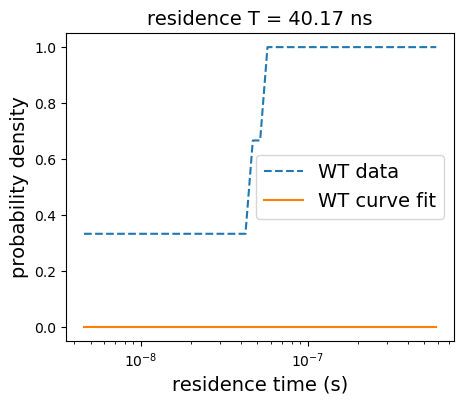

In [66]:
data = residence_t_data

x_min, x_max = np.min(data),np.max(data)
log_bin = np.logspace(np.log10(x_min),np.log10(x_max), 50)
count, bins_count = np.histogram(data, bins=log_bin)
bin_centers = 0.5 * (bins_count[1:] + bins_count[:-1])

pdf = count/sum(count)
cdf = np.cumsum(pdf)

plt.figure(figsize=(5,4))
plt.plot(bin_centers, cdf,'--',label='WT data')
plt.xlabel(r'residence time (s)',fontsize=14)
plt.ylabel('probability density',fontsize=14)

def fit_function(k, lamb):
    return expon.cdf(k,0,lamb)

# curve_fit with the poisson cdf 
parameters, cov_matrix = curve_fit(fit_function, bin_centers, cdf)
parameters*=10**9
print('tau =',parameters)

fit_results = fit_function(bin_centers, parameters)
plt.plot(bin_centers,fit_results,label='WT curve fit')
plt.xscale('log')
plt.legend(fontsize = 14)
plt.title(r'residence T = %2.2f ns'%parameters,fontsize = 14)

stats.kstest(data,expon.cdf,(0, parameters))
